<a href="https://colab.research.google.com/github/TMhdSofyan/KAUST-Hackathon-EnergyHarvest/blob/main/09_UpdateNeuralNetwork_EarlyStopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
!pip install jcopml "jcopdl<2.0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [6]:
df = pd.read_csv('/content/03_Training_df2.csv', index_col="case_num")
df['oil_prod_cum'] = df['oil_prod_cum'] * 1e-5
df.head()

,days,years,oil_prod_rate,oil_prod_cum,water_inj_rate,water_inj_cum,category,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
case_num,,,,,,,,,,,,,
0,0,0.000000,0.0,0.00000,0.00,0.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,31,0.084932,26614.0,8.25035,1740.71,53962.1,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,62,0.169863,21427.7,14.89290,1740.71,107924.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,93,0.254795,18809.7,20.72390,1740.71,161886.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,124,0.339726,16676.6,25.89370,1740.71,215848.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


In [33]:
X = df.drop(columns=["oil_prod_rate", 'days', 'oil_prod_cum', 'water_inj_rate', 'water_inj_cum', 'category']) #'oil_prod_cum_10e5'])
y = df.oil_prod_cum.values #For convert this value from DataFrame to Array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((62250, 7), (20750, 7), (62250,), (20750,))

#Sample Data

In [34]:
X.head() #X data is still in DataFrame format

,years,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
case_num,,,,,,,
0,0.000000,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,0.084932,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,0.169863,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,0.254795,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
0,0.339726,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


In [35]:
preprocessor = ColumnTransformer([
    ('numeric1', num_pipe(scaling = 'minmax'), ['inj_rate', 'prod_bhp', 'permeability']),
    ('numeric2', num_pipe(), ['Kh_Kv', 'years', 'porosity', 'thickness'])
])

In [36]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [37]:
y_test #now the data is converted into array

array([148.647 ,  91.6132, 229.84  , ..., 452.777 , 171.447 ,  14.7006])

---------------------------------------------

#STEP 1: DATASET & DATALOADER
Data loader --> aims to create the mini batch

In [38]:
import torch
from torch. utils.data import DataLoader, TensorDataset

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [40]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train.reshape(-1, 1))
y_test = torch.FloatTensor(y_test.reshape(-1, 1))

In [41]:
# Create dataset (train & test) with the tensor data above and also create dataloader
train_set = TensorDataset(X_train, y_train)
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)

test_set = TensorDataset(X_test, y_test)
testloader = DataLoader(test_set, batch_size=64)

-----------------------------------------------------------

#**Step 2 : Architecture and Configuration**

In [43]:
#import neural network
from torch import nn

In [72]:
from jcopdl.layers import linear_block
class NN(nn.Module):
    def __init__(self, input_size, output_size, dropout = 0.2):
        super().__init__()
        self.fc = nn.Sequential(
            linear_block(input_size, 32, dropout=dropout),
            linear_block(32, 128, dropout=dropout),
            linear_block(128, 128, dropout=dropout),
            linear_block(128, output_size, activation=None)
        )

    def forward(self, x):
        return self.fc(x)

In [73]:
from jcopdl.callback import Callback, set_config

In [74]:
config = set_config({
    "input_size": 7,
    "output_size": 1,
    "dropout": 0.3
})

____

#**Step 3: Training Preparation**
Prepare model, criterion, and optimizer

##Model

In [84]:
from torch import optim

model = NN(config.input_size, config.output_size, config.dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.005)
callback = Callback(model, config, early_stop_patience=10, outdir = 'model')

-------------------

#**Step 4: Training Loop**

In [85]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):   #feature = X , Target = y
        feature, target = feature.to(device), target.to(device)
        output = model(feature) # model
        loss = criterion(output, target) #criterion output vs target

        if mode == "train":
            loss.backward() #backpropagation
            optimizer.step() #update weigh
            optimizer.zero_grad() #reset optimizer to 0

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 4703.6705 | Test_cost  = 5088.1864 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 3017.7601 | Test_cost  = 3978.8538 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 2137.9024 | Test_cost  = 5016.8586 | 
==> EarlyStop patience =  1 | Best test_cost: 3978.8538


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 1900.2876 | Test_cost  = 4136.1030 | 
==> EarlyStop patience =  2 | Best test_cost: 3978.8538


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 1731.1533 | Test_cost  = 6002.7420 | 
==> EarlyStop patience =  3 | Best test_cost: 3978.8538


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 1613.8720 | Test_cost  = 4968.4876 | 
==> EarlyStop patience =  4 | Best test_cost: 3978.8538


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 1652.1229 | Test_cost  = 5342.2433 | 
==> EarlyStop patience =  5 | Best test_cost: 3978.8538


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 1537.6952 | Test_cost  = 4894.3595 | 
==> EarlyStop patience =  6 | Best test_cost: 3978.8538


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 1611.1846 | Test_cost  = 4810.8790 | 
==> EarlyStop patience =  7 | Best test_cost: 3978.8538


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 1469.7350 | Test_cost  = 6705.6934 | 
==> EarlyStop patience =  8 | Best test_cost: 3978.8538


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 1436.5933 | Test_cost  = 3309.9104 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 1484.7377 | Test_cost  = 5682.0644 | 
==> EarlyStop patience =  1 | Best test_cost: 3309.9104


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 1452.5782 | Test_cost  = 6836.6314 | 
==> EarlyStop patience =  2 | Best test_cost: 3309.9104


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 1442.3686 | Test_cost  = 6681.7026 | 
==> EarlyStop patience =  3 | Best test_cost: 3309.9104


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 1436.6770 | Test_cost  = 5515.8554 | 
==> EarlyStop patience =  4 | Best test_cost: 3309.9104


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 1377.0590 | Test_cost  = 4215.3116 | 
==> EarlyStop patience =  5 | Best test_cost: 3309.9104


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 1424.5661 | Test_cost  = 7602.5141 | 
==> EarlyStop patience =  6 | Best test_cost: 3309.9104


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 1446.9008 | Test_cost  = 6680.7204 | 
==> EarlyStop patience =  7 | Best test_cost: 3309.9104


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 1424.6072 | Test_cost  = 5930.8216 | 
==> EarlyStop patience =  8 | Best test_cost: 3309.9104


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 1390.1726 | Test_cost  = 6358.6568 | 


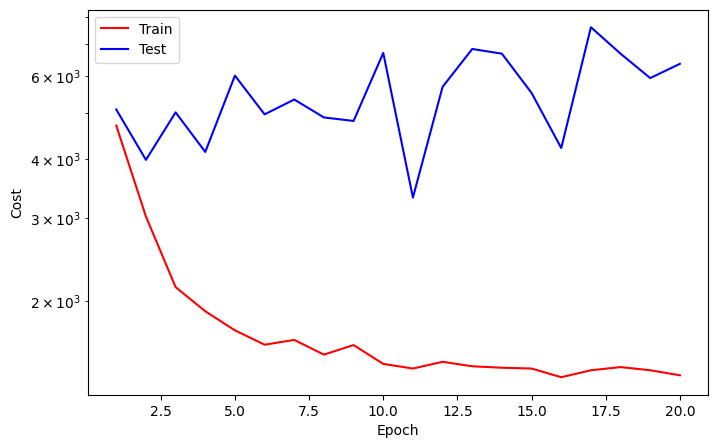

==> EarlyStop patience =  9 | Best test_cost: 3309.9104


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 1374.4394 | Test_cost  = 6725.1706 | 
==> EarlyStop patience = 10 | Best test_cost: 3309.9104
==> Execute Early Stopping at epoch: 21 | Best test_cost: 3309.9104
==> Best model is saved at model


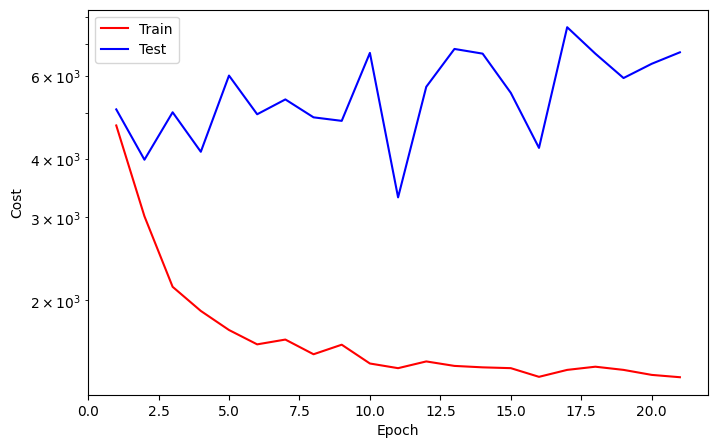

In [86]:
while True:
    train_cost= loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost= loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

#EVALUATION

In [87]:
with torch.no_grad():
    model.eval()
    output = model(X_test)
output.shape

torch.Size([20750, 1])

In [88]:
output = output.reshape(-1)
output

tensor([118.3137,  82.0773, 160.9024,  ..., 255.9767, 124.5060,  42.1969])

In [89]:
y_test

tensor([[148.6470],
        [ 91.6132],
        [229.8400],
        ...,
        [452.7770],
        [171.4470],
        [ 14.7006]])

In [90]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test.numpy(), output.numpy())
mse

3309.9106

In [91]:
from sklearn.metrics import r2_score
test_r2 = r2_score(y_test.numpy(), output.numpy())
test_r2

0.6861328696375367